In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
import sklearn
import math
import pydotplus
from sklearn import tree
import collections


from pandas import Series, DataFrame
from pylab import rcParams
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import train_test_split
from sklearn import metrics 
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB, BernoulliNB, MultinomialNB

/Users/yinchiahuang/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


#### Read data

In [2]:
customers = pd.read_csv('/Users/yinchiahuang/Library/Mobile Documents/com~apple~CloudDocs/CS677/Final project/data/customers.csv')
geolocation = pd.read_csv('/Users/yinchiahuang/Library/Mobile Documents/com~apple~CloudDocs/CS677/Final project/data/geolocation.csv')
order_items = pd.read_csv('/Users/yinchiahuang/Library/Mobile Documents/com~apple~CloudDocs/CS677/Final project/data/order_items.csv')
order_payments = pd.read_csv('/Users/yinchiahuang/Library/Mobile Documents/com~apple~CloudDocs/CS677/Final project/data/order_payments.csv')
order_reviews = pd.read_csv('/Users/yinchiahuang/Library/Mobile Documents/com~apple~CloudDocs/CS677/Final project/data/order_reviews.csv')
orders = pd.read_csv('/Users/yinchiahuang/Library/Mobile Documents/com~apple~CloudDocs/CS677/Final project/data/orders.csv')
products = pd.read_csv('/Users/yinchiahuang/Library/Mobile Documents/com~apple~CloudDocs/CS677/Final project/data/products.csv')
sellers = pd.read_csv('/Users/yinchiahuang/Library/Mobile Documents/com~apple~CloudDocs/CS677/Final project/data/sellers.csv')
product_category_name_translation = pd.read_csv('/Users/yinchiahuang/Library/Mobile Documents/com~apple~CloudDocs/CS677/Final project/data/product_category_name_translation.csv')


#### Data preparation

In [3]:
# translate product category name to English
category_name_dict = dict(zip( product_category_name_translation.product_category_name,product_category_name_translation.product_category_name_english,))
categories = list(products['product_category_name'])
translated_category_name_dict = {k:v for k,v in category_name_dict.items()}
translated_categories =[translated_category_name_dict.get(item,item)  for item in categories]
products['product_category_name'] = translated_categories

In [4]:
# Lets see the info of our dataset
customers.info()
geolocation.info()
order_items.info()
order_payments.info()
order_reviews.info()
orders.info()
products.info()
sellers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 5 columns):
customer_id                 99441 non-null object
customer_unique_id          99441 non-null object
customer_zip_code_prefix    99441 non-null int64
customer_city               99441 non-null object
customer_state              99441 non-null object
dtypes: int64(1), object(4)
memory usage: 3.8+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000163 entries, 0 to 1000162
Data columns (total 5 columns):
geolocation_zip_code_prefix    1000163 non-null int64
geolocation_lat                1000163 non-null float64
geolocation_lng                1000163 non-null float64
geolocation_city               1000163 non-null object
geolocation_state              1000163 non-null object
dtypes: float64(2), int64(1), object(2)
memory usage: 38.2+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112650 entries, 0 to 112649
Data columns (total 6 columns):
order_id         112650 non-null

- ovder_reviews table has nan values: some reviews don't have 
   1. review_comment_title
   2. review_comment_message
- orders table has nan values: some reviews don't have 
   1. order_approved_at
   2. order_delivered_carrier_date
   3. order_delivered_customer_date
- products table has nan values: some products don't have
  1. product_category_name
  2. product_name_lenght
  3. product_description_lenght
  4. product_photos_qty
  5. product_weight_g
  6. product_length_cm
  7. product_height_cm
  8. product_width_cm          

In [5]:
# Convert datetime features to the correct format
orders.order_purchase_timestamp = pd.to_datetime(orders.order_purchase_timestamp)
orders.order_approved_at = pd.to_datetime(orders.order_approved_at)
orders.order_delivered_carrier_date = pd.to_datetime(orders.order_delivered_carrier_date )
orders.order_delivered_customer_date = pd.to_datetime(orders.order_delivered_customer_date)
orders.order_estimated_delivery_date = pd.to_datetime(orders.order_estimated_delivery_date)

### Discriptive Analysis

##### Customer
##### Where are customers from? Which state? Which city?

In [6]:
# Group by state
groupby_state = customers.groupby(['customer_state'])
print ("Grouping by state and aggregating #of customers")
print (groupby_state['customer_id'].agg(['count']))


Grouping by state and aggregating #of customers
                count
customer_state       
AC                 81
AL                413
AM                148
AP                 68
BA               3380
CE               1336
DF               2140
ES               2033
GO               2020
MA                747
MG              11635
MS                715
MT                907
PA                975
PB                536
PE               1652
PI                495
PR               5045
RJ              12852
RN                485
RO                253
RR                 46
RS               5466
SC               3637
SE                350
SP              41746
TO                280


In [7]:
# Group by state and city
groupby_state_city = customers.groupby(['customer_state', 'customer_city'])
print ("Grouping by state and city, and aggregating #of customers")
print (groupby_state_city['customer_id'].agg(['count']))

Grouping by state and city, and aggregating #of customers
                                        count
customer_state customer_city                 
AC             brasileia                    1
               cruzeiro do sul              3
               epitaciolandia               1
               manoel urbano                1
               porto acre                   1
               rio branco                  70
               senador guiomard             2
               xapuri                       2
AL             agua branca                  1
               anadia                       2
               arapiraca                   29
               atalaia                      1
               barra de santo antonio       2
               barra de sao miguel          2
               batalha                      3
               belem                        3
               boca da mata                 2
               cacimbinhas                  1
               cajueir

#### visualization

In [8]:
#http://ramiro.org/notebook/geopandas-choropleth/
#geolocation

##### Order
- How many items customers bought per order? 

count    98666.000000
mean         1.141731
std          0.538452
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max         21.000000
Name: count, dtype: float64


Text(0, 0.5, 'frequency')

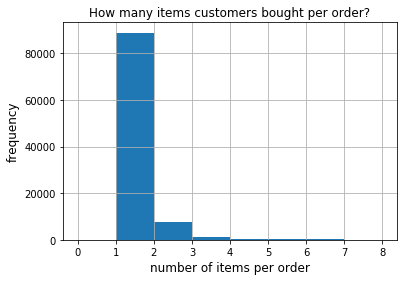

In [9]:
# Group by order and aggregate #of items
order_amount_df = order_items.groupby('order_id').agg(
    {'order_id':['count']})

s = order_amount_df['order_id']['count']
print(s.describe())
count, division = np.histogram(s, bins = list(range(0,9,1)))
s.hist(bins=division)
plt.title('How many items customers bought per order?', fontsize=12)
plt.xlabel('number of items per order', fontsize=12)
plt.ylabel('frequency', fontsize=12)


- How much do cutomers spend per order? 

In [10]:
# Group by order and aggregate price and shipping fee
order_expense_df = order_items.groupby('order_id').agg(
    {'price':['sum'],
     'freight_value':['sum']})

count    98666.000000
mean       137.754076
std        210.645145
min          0.850000
25%         45.900000
50%         86.900000
75%        149.900000
max      13440.000000
Name: sum, dtype: float64


Text(0, 0.5, 'frequency')

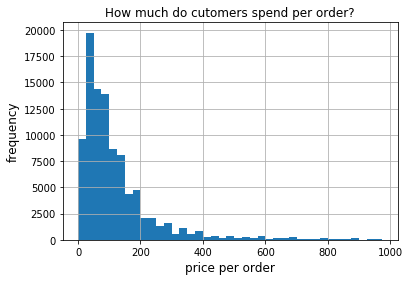

In [11]:
s = order_expense_df['price']['sum']
print(s.describe())
count, division = np.histogram(s, bins = list(range(0,1000,25)))
s.hist(bins=division)
plt.title('How much do cutomers spend per order?', fontsize=12)
plt.xlabel('price per order', fontsize=12)
plt.ylabel('frequency', fontsize=12)

- How much do cutomers pay for shipping per order?

count    98666.000000
mean        22.823562
std         21.650909
min          0.000000
25%         13.850000
50%         17.170000
75%         24.040000
max       1794.960000
Name: sum, dtype: float64


Text(0, 0.5, 'frequency')

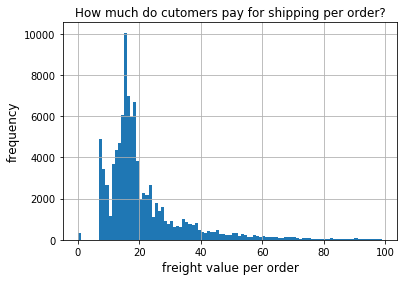

In [12]:
s = order_expense_df['freight_value']['sum']
print(s.describe())
count, division = np.histogram(s, bins = list(range(0,100,1)))
s.hist(bins=division)
plt.title('How much do cutomers pay for shipping per order?', fontsize=12)
plt.xlabel('freight value per order', fontsize=12)
plt.ylabel('frequency', fontsize=12)

- When are people more likely to order purchase? 

In [13]:
# join orders table and order_payments table in order to see the relation of orders and time 
time_revenue_df = pd.merge(orders, order_payments, on='order_id')
time_revenue_df = time_revenue_df[['order_id','order_purchase_timestamp','payment_type','payment_value']]
time_revenue_df
# extract year/month/date/hour 
time_revenue_df['Year'] = pd.DatetimeIndex(time_revenue_df['order_purchase_timestamp']).year
time_revenue_df['Month'] = pd.DatetimeIndex(time_revenue_df['order_purchase_timestamp']).month
time_revenue_df['month_year'] = pd.to_datetime(time_revenue_df['order_purchase_timestamp']).dt.to_period('M')
time_revenue_df['Date'] = pd.DatetimeIndex(time_revenue_df['order_purchase_timestamp']).day
time_revenue_df['Day_name'] = pd.DatetimeIndex(time_revenue_df['order_purchase_timestamp']).weekday_name
time_revenue_df['Hour'] = pd.DatetimeIndex(time_revenue_df['order_purchase_timestamp']).hour
time_revenue_df 


,order_id,order_purchase_timestamp,payment_type,payment_value,Year,Month,month_year,Date,Day_name,Hour
0,e481f51cbdc54678b7cc49136f2d6af7,2017-10-02 10:56:33,credit_card,18.12,2017,10,2017-10,2,Monday,10
1,e481f51cbdc54678b7cc49136f2d6af7,2017-10-02 10:56:33,voucher,2.00,2017,10,2017-10,2,Monday,10
2,e481f51cbdc54678b7cc49136f2d6af7,2017-10-02 10:56:33,voucher,18.59,2017,10,2017-10,2,Monday,10
3,53cdb2fc8bc7dce0b6741e2150273451,2018-07-24 20:41:37,boleto,141.46,2018,7,2018-07,24,Tuesday,20
4,47770eb9100c2d0c44946d9cf07ec65d,2018-08-08 08:38:49,credit_card,179.12,2018,8,2018-08,8,Wednesday,8
5,949d5b44dbf5de918fe9c16f97b45f8a,2017-11-18 19:28:06,credit_card,72.20,2017,11,2017-11,18,Saturday,19
6,ad21c59c0840e6cb83a9ceb5573f8159,2018-02-13 21:18:39,credit_card,28.62,2018,2,2018-02,13,Tuesday,21
7,a4591c265e18cb1dcee52889e2d8acc3,2017-07-09 21:57:05,credit_card,175.26,2017,7,2017-07,9,Sunday,21
8,136cce7faa42fdb2cefd53fdc79a6098,2017-04-11 12:22:08,credit_card,65.95,2017,4,2017-04,11,Tuesday,12
9,6514b8ad8028c9f2cc2374ded245783f,2017-05-16 13:10:30,credit_card,75.16,2017,5,2017-05,16,Tuesday,13


In [14]:
monthly_profit = time_revenue_df.groupby('month_year',as_index=False).agg(
    {'order_id':['count'],
     'payment_value':['sum']})
monthly_profit

,month_year,order_id,payment_value
,,count,sum
0,2016-09,3,252.24
1,2016-10,342,59090.48
2,2016-12,1,19.62
3,2017-01,850,138488.04
4,2017-02,1886,291908.01
5,2017-03,2837,449863.60
6,2017-04,2571,417788.03
7,2017-05,3944,592918.82
8,2017-06,3436,511276.38


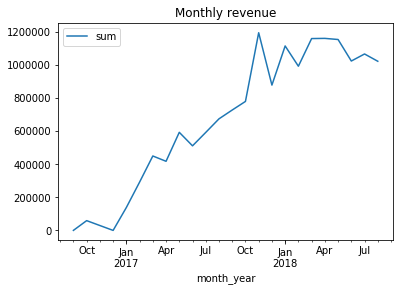

In [15]:
monthly_profit[:-2].plot(x='month_year', y='payment_value',title='Monthly revenue')

#### Sellers
- Which seller is the most popular? in terms of # of products sold

In [16]:
# join order_items table and order_payments table in order to see the relation of sellers the revenue they brought in 
items_payment_df = pd.merge(order_items, order_payments, on='order_id')

count    3095.000000
mean       37.997092
std       124.409139
min         1.000000
25%         2.000000
50%         8.000000
75%        26.000000
max      2133.000000
Name: count, dtype: float64
Top 10 sellers: seller_id
4a3ca9315b744ce9f8e9374361493884    2133
6560211a19b47992c3666cc44a7e94c0    2122
1f50f920176fa81dab994f9023523100    2008
cc419e0650a3c5ba77189a1882b7556a    1847
da8622b14eb17ae2831f4ac5b9dab84a    1639
955fee9216a65b617aa5c0531780ce60    1528
1025f0e2d44d7041d6cf58b6550e0bfa    1462
7c67e1448b00f6e969d365cea6b010ab    1452
7a67c85e85bb2ce8582c35f2203ad736    1240
ea8482cd71df3c1969d7b9473ff13abc    1239
Name: count, dtype: int64


Text(0, 0.5, 'Sellers')

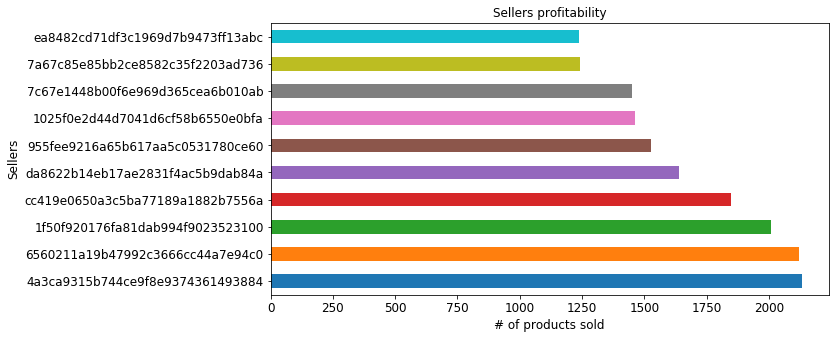

In [17]:
seller_productsSold_profit = items_payment_df.groupby('seller_id').agg(
    {'product_id':['count'],
     'payment_value':['sum']})

# Visualize seller's profitability in terms of  # of products sold
s = seller_productsSold_profit['product_id']['count']
print(s.describe())
s_best = s.sort_values(ascending=False).head(10)

print("Top 10 sellers:",s_best)

plt.figure(figsize=(10, 5))
ax = s_best.plot(kind='barh', fontsize=12)
ax.set_title('Seller''s profitability')
ax.set_xlabel('# of products sold', fontsize=12)
ax.set_ylabel('Sellers', fontsize=12)


- Which sellers are the most/least profitable? in terms of payment value

count      3095.000000
mean       6561.594414
std       21537.946021
min          12.220000
25%         317.850000
50%        1250.660000
75%        4879.240000
max      507166.910000
Name: sum, dtype: float64


Text(0, 0.5, 'Sellers')

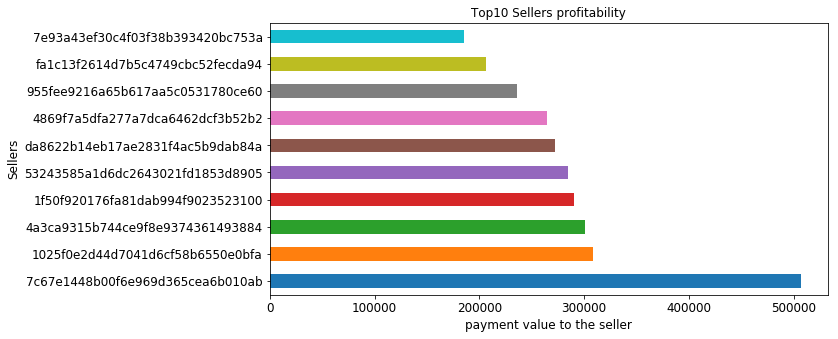

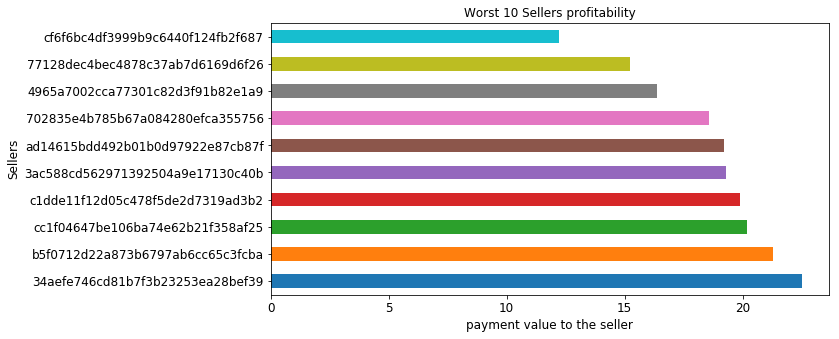

In [18]:
# Visualize sellers' profitability in terms of payment value
s = seller_productsSold_profit['payment_value']['sum']
print(s.describe())

# top 10 sellers
s_best = s.sort_values(ascending=False).head(10)
plt.figure(figsize=(10,5))
ax = s_best.plot(kind='barh', fontsize=12)
ax.set_title('Top10 Seller''s profitability')
ax.set_xlabel('payment value to the seller', fontsize=12)
ax.set_ylabel('Sellers', fontsize=12)

# Worst 10 sellers
s_worst = s.sort_values(ascending=False).tail(10)
plt.figure(figsize=(10,5))
ax = s_worst.plot(kind='barh', fontsize=12)
ax.set_title('Worst 10 Seller''s profitability')
ax.set_xlabel('payment value to the seller', fontsize=12)
ax.set_ylabel('Sellers', fontsize=12)

##### Product

In [19]:
# join order_items table and order_reviews table in order to see the relation of products and their reviews
items_reviews_df = pd.merge(pd.merge(order_items, order_reviews, on='order_id'), products, on= 'product_id')
# get the average review scores and the numbers of reviews for each product category
product_category_reviews = items_reviews_df.groupby(['product_category_name']).agg(
{'review_score':['mean','count']})

- Which product category has most reviews?

Text(0, 0.5, 'Product category')

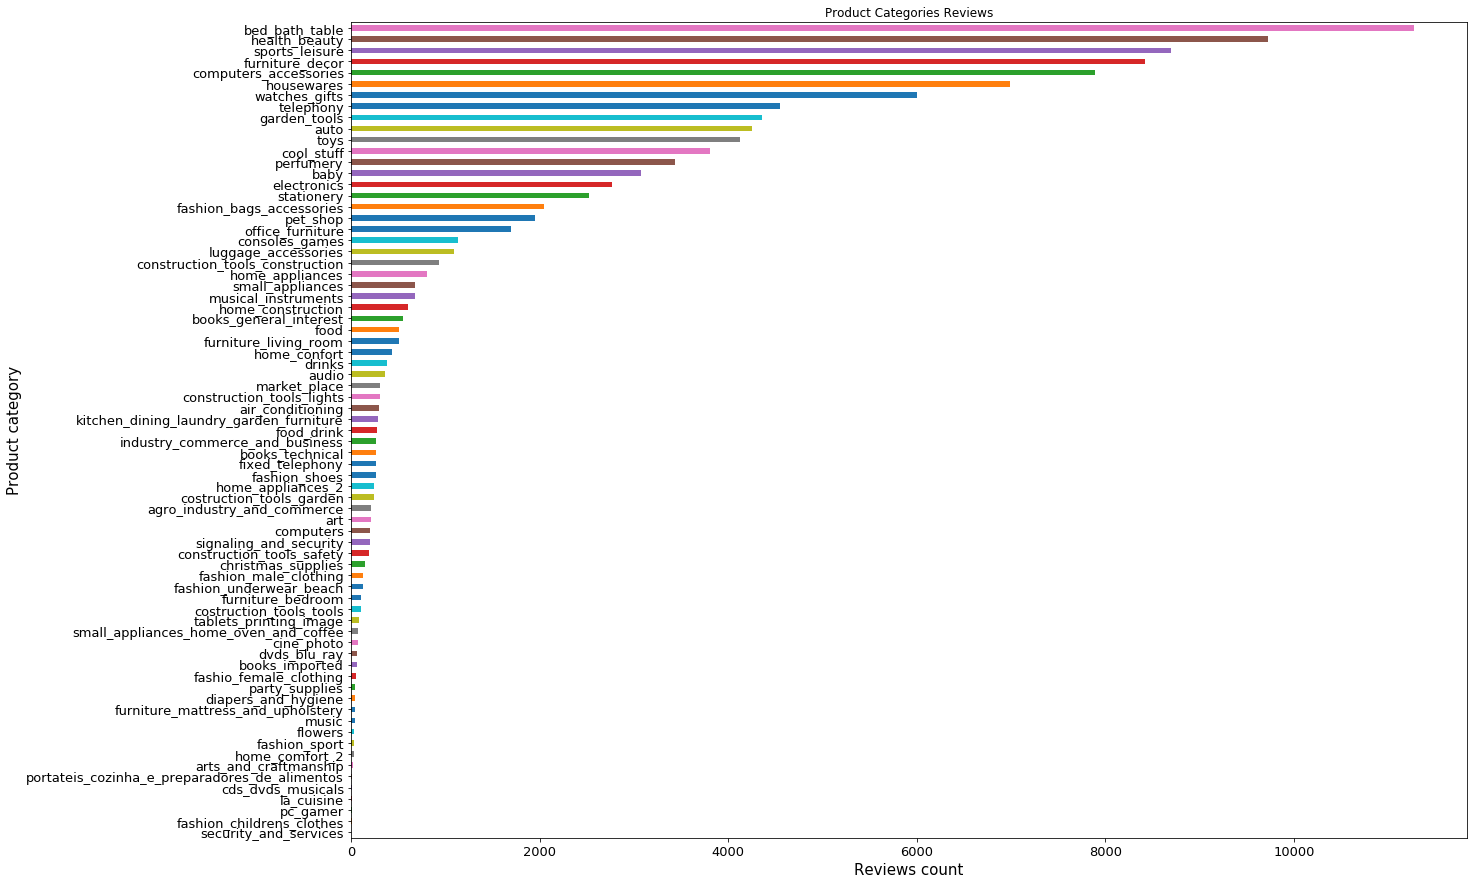

In [20]:
# Visualize product category's reviews' count
s = product_category_reviews['review_score']['count']
s = s.sort_values(ascending=True)
plt.figure(figsize=(20, 15))
ax = s.plot(kind='barh', fontsize=13)
ax.set_title('Product Categories'' Reviews')
ax.set_xlabel('Reviews count', fontsize=15)
ax.set_ylabel('Product category', fontsize=15)

- Which product category has best average reviews

Text(0, 0.5, 'Product category')

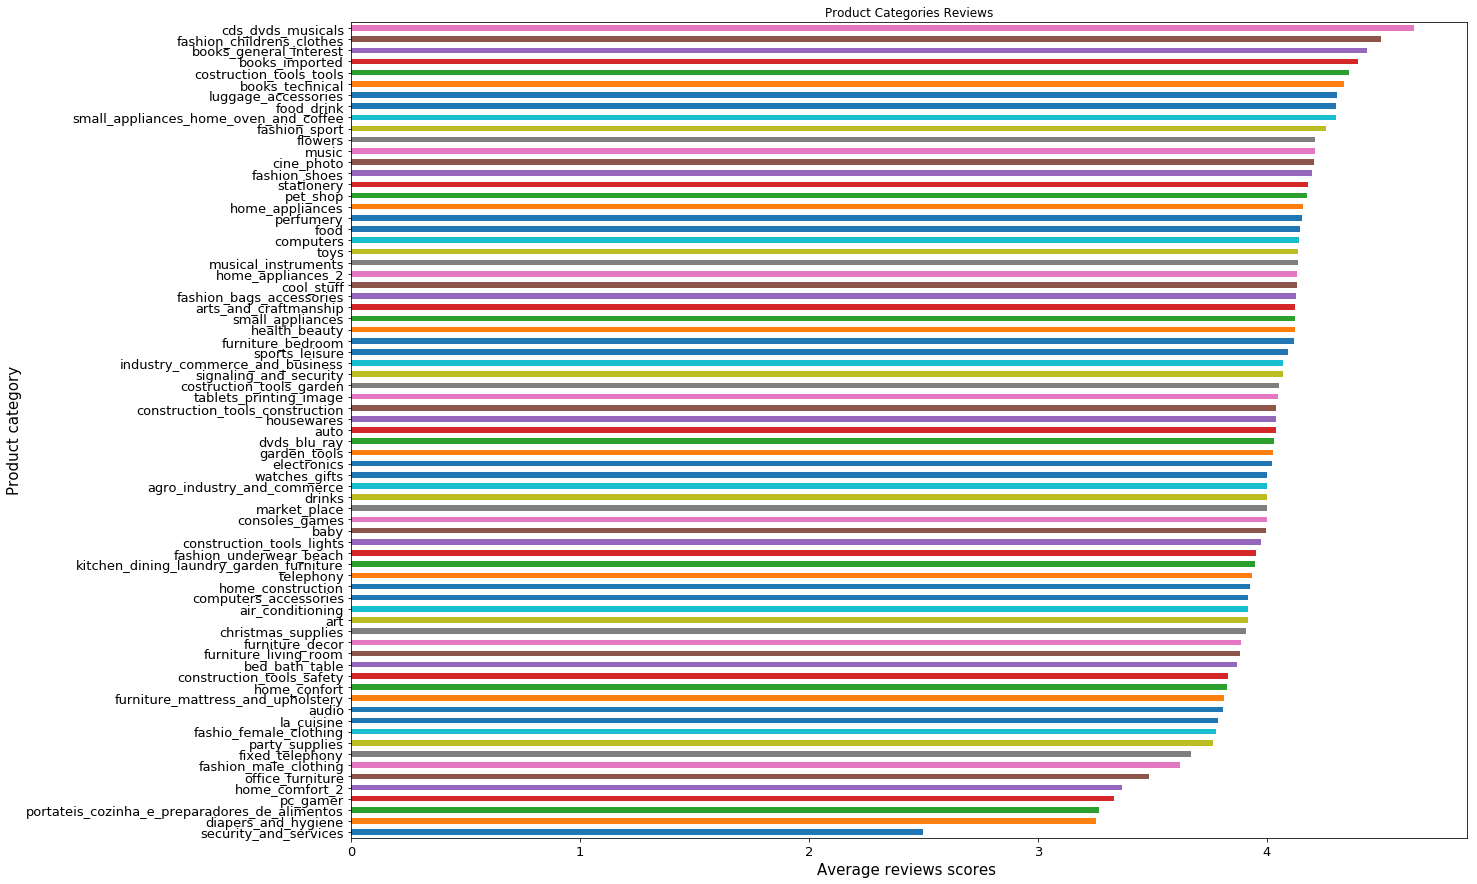

In [21]:
# Visualize product category's average reviews scores
s = product_category_reviews['review_score']['mean']
s = s.sort_values(ascending=True)
plt.figure(figsize=(20, 15))
ax = s.plot(kind='barh', fontsize=13)
ax.set_title('Product Categories'' Reviews')
ax.set_xlabel('Average reviews scores ', fontsize=15)
ax.set_ylabel('Product category', fontsize=15)

#### Translate order reviews and generate word cloud to see the relation between review text and scores

- Because it takes a long time to connecting to google clound and translate, I saved the transalted file into CSV and commented the code so that we don't have to run again every time we restart the program

In [31]:
translated_review = pd.read_csv('/Users/yinchiahuang/Library/Mobile Documents/com~apple~CloudDocs/CS677/Final project/translated_review.csv')
df_reviews_without_na = translated_review.dropna()

- Who are more likely to leave a review comment? Satisfied customers or unsatisfied people? 

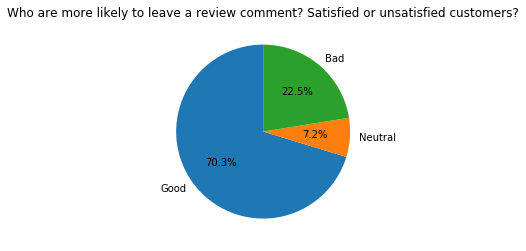

In [32]:
df_good_reviews = df_reviews_without_na.loc[df_reviews_without_na['review score'].isin([4,5])]
df_ok_reviews = df_reviews_without_na.loc[df_reviews_without_na['review score']==3]
df_bad_reviews = df_reviews_without_na.loc[df_reviews_without_na['review score'].isin([1,2])]


reviews_count = [len(df_good_reviews),len(df_ok_reviews), len(df_bad_reviews)]
reviews_score = ['Good', 'Neutral', 'Bad']
plt.pie(reviews_count, labels=reviews_score, startangle=90, autopct='%.1f%%')
plt.title('Who are more likely to leave a review comment? Satisfied or unsatisfied customers?')
plt.show()

- Review scores V.S review text

In [33]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
stopwords = set(STOPWORDS)
STOPWORDS2 = ['product','exactly','actually']
stopwords2 = set(STOPWORDS2)
stopwords.update(stopwords2)
stopwords -= {'can',"can't",'cannot',"doesn't",'get','no',
 'nor',
 'not','had',"hadn't",'has',"hasn't",'have',"haven't"}


def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stopwords,
        max_words=200,
        max_font_size=40, 
        scale=3,
        random_state=1 # chosen at random by flipping a coin; it was heads
    ).generate(str(data))

    fig = plt.figure(1, figsize=(12, 12))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()



good reviews:


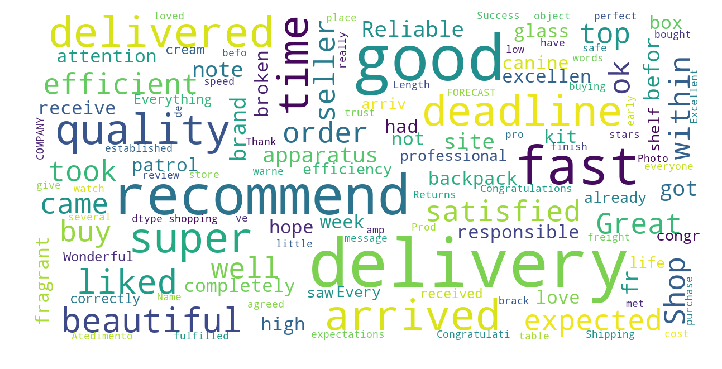

neutral reviews:


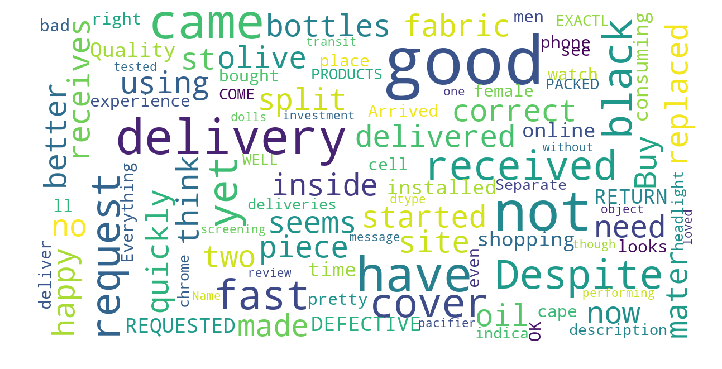

bad reviews:


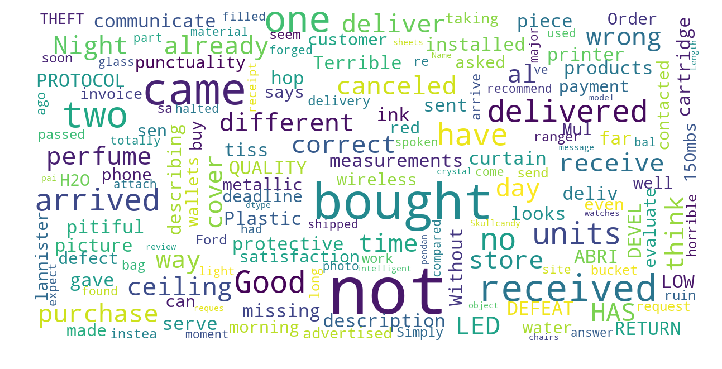

In [34]:
print('good reviews:')
show_wordcloud(df_good_reviews['review message'])
print('neutral reviews:')
show_wordcloud(df_ok_reviews['review message'])
print('bad reviews:')
show_wordcloud(df_bad_reviews['review message'])

In [35]:
# customer_id: key to the orders dataset. Each order has a unique customer_id.
# customer_unique_id: unique identifier of a customer.
customers

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP
5,879864dab9bc3047522c92c82e1212b8,4c93744516667ad3b8f1fb645a3116a4,89254,jaragua do sul,SC
6,fd826e7cf63160e536e0908c76c3f441,addec96d2e059c80c30fe6871d30d177,4534,sao paulo,SP
7,5e274e7a0c3809e14aba7ad5aae0d407,57b2a98a409812fe9618067b6b8ebe4f,35182,timoteo,MG
8,5adf08e34b2e993982a47070956c5c65,1175e95fb47ddff9de6b2b06188f7e0d,81560,curitiba,PR
9,4b7139f34592b3a31687243a302fa75b,9afe194fb833f79e300e37e580171f22,30575,belo horizonte,MG


Grouping by unique_customer and aggregating #of olders
Counter({1: 93099, 2: 2745, 3: 203, 4: 30, 5: 8, 6: 6, 7: 3, 17: 1, 9: 1})
dict_keys([17, 9, 7, 6, 5, 4, 3, 2, 1])
dict_values([1, 1, 3, 6, 8, 30, 203, 2745, 93099])
[0.0, 0.0, 0.0, 0.01, 0.01, 0.03, 0.21, 2.86, 96.88]


([<matplotlib.patches.Wedge at 0x1a32504b00>,
 [Text(1.1, 0.0, '17'),
  Text(1.1, 0.0, '9'),
  Text(1.1, 0.0, '7'),
  Text(1.099999945717179, 0.0003455751774804301, '6'),
  Text(1.099999511454643, 0.0010367253960136898, '5'),
  Text(1.0999973401428755, 0.0024190243072331396, '4'),
  Text(1.0999478346221105, 0.01071266120675012, '3'),
  Text(1.0938043380044244, 0.11658503404255172, '2'),
  Text(-1.094720139500309, -0.10764671928314577, '1')])

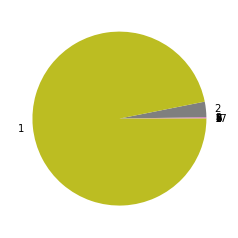

In [38]:
# Group by unique customers
groupby_unique_customer = customers.groupby(['customer_unique_id'])
print ("Grouping by unique_customer and aggregating #of olders")
grouped_customers = groupby_unique_customer['customer_id'].agg(['count'])
grouped_customers = grouped_customers.sort_values('count', ascending=False)
grouped_customers

# How's customers' loyalty?
import collections
order_counts = grouped_customers['count']
counter=collections.Counter(order_counts)

print(counter)

number_of_order = counter.keys()
print(number_of_order)
values = counter.values()
total = sum(values)
print(values)
percentage = [round(value * 100. / total,2) for value in values]
print(percentage)

# dict_keys: How many orders are from the same customer?
# dict_values : How often it happens?
# percentage: viualize the frequency 

import matplotlib.pyplot as pyplot
pyplot.pie([float(v) for v in percentage], labels=[int(k) for k in number_of_order],
           autopct=None)

In [39]:
grouped_customers['old_customer'] = np.where(grouped_customers['count']> 1,1,0)
grouped_customers

,count,old_customer
customer_unique_id,,
8d50f5eadf50201ccdcedfb9e2ac8455,17,1
3e43e6105506432c953e165fb2acf44c,9,1
6469f99c1f9dfae7733b25662e7f1782,7,1
ca77025e7201e3b30c44b472ff346268,7,1
1b6c7548a2a1f9037c1fd3ddfed95f33,7,1
12f5d6e1cbf93dafd9dcc19095df0b3d,6,1
de34b16117594161a6a89c50b289d35a,6,1
63cfc61cee11cbe306bff5857d00bfe4,6,1
f0e310a6839dce9de1638e0fe5ab282a,6,1


Customers' loyalty are low. Among all the orders:
- 96.88% are from new customers
- 2.86% are bought from customers who purchased two times on this marketplace.
- 0.21% are bought from customers who purchased three times on this marketplace.
- 0.03% are bought from customers who purchased four times on this marketplace.

There is one most loyal customer who have purchased 17 times on this marketplace.


#### Shipping time vs review score

In [44]:
# join orders table and order_payments table in order to see the relation of orders and time 
review_delivery_df = pd.merge(orders, order_reviews, on='order_id')
review_delivery_df = review_delivery_df[['order_id','review_score','order_purchase_timestamp','order_delivered_customer_date','order_estimated_delivery_date']]
review_delivery_df

review_delivery_df['actual_waiting_time'] = review_delivery_df['order_delivered_customer_date'] - review_delivery_df['order_purchase_timestamp']
review_delivery_df['estimated_waiting_time'] = review_delivery_df['order_estimated_delivery_date'] - review_delivery_df['order_purchase_timestamp']
review_delivery_df['wait_for_too_long'] = np.where(review_delivery_df['actual_waiting_time']>=review_delivery_df['estimated_waiting_time'],1,0)

review_delivery_df

,order_id,review_score,order_purchase_timestamp,order_delivered_customer_date,order_estimated_delivery_date,actual_waiting_time,estimated_waiting_time,wait_for_too_long
0,e481f51cbdc54678b7cc49136f2d6af7,4,2017-10-02 10:56:33,2017-10-10 21:25:13,2017-10-18,8 days 10:28:40,15 days 13:03:27,0
1,53cdb2fc8bc7dce0b6741e2150273451,4,2018-07-24 20:41:37,2018-08-07 15:27:45,2018-08-13,13 days 18:46:08,19 days 03:18:23,0
2,47770eb9100c2d0c44946d9cf07ec65d,5,2018-08-08 08:38:49,2018-08-17 18:06:29,2018-09-04,9 days 09:27:40,26 days 15:21:11,0
3,949d5b44dbf5de918fe9c16f97b45f8a,5,2017-11-18 19:28:06,2017-12-02 00:28:42,2017-12-15,13 days 05:00:36,26 days 04:31:54,0
4,ad21c59c0840e6cb83a9ceb5573f8159,5,2018-02-13 21:18:39,2018-02-16 18:17:02,2018-02-26,2 days 20:58:23,12 days 02:41:21,0
5,a4591c265e18cb1dcee52889e2d8acc3,4,2017-07-09 21:57:05,2017-07-26 10:57:55,2017-08-01,16 days 13:00:50,22 days 02:02:55,0
6,136cce7faa42fdb2cefd53fdc79a6098,2,2017-04-11 12:22:08,NaT,2017-05-09,NaT,27 days 11:37:52,0
7,6514b8ad8028c9f2cc2374ded245783f,5,2017-05-16 13:10:30,2017-05-26 12:55:51,2017-06-07,9 days 23:45:21,21 days 10:49:30,0
8,76c6e866289321a7c93b82b54852dc33,1,2017-01-23 18:29:09,2017-02-02 14:08:10,2017-03-06,9 days 19:39:01,41 days 05:30:51,0
9,e69bfb5eb88e0ed6a785585b27e16dbf,5,2017-07-29 11:55:02,2017-08-16 17:14:30,2017-08-23,18 days 05:19:28,24 days 12:04:58,0


#### Classification models comparison:
Build different classification models to predict/classify review score
- classifiers:
   1. Logistic Regression
   2. KNN
   3. Naïve Bayesian
   4. K means
   5. Decision Tree
   6. Random forest
- related facotrs/attributes : 
   1. product category
   2. actual waiting time 
   3. waiting for too long
   4. product price
   5. shipping price
   6. old/new customer (purchased more than 1 times) 
- class labels:
   1. review score = 1
   2. review score = 2
   3. review score = 3
   4. review score = 4
   5. review score = 5


##### Prepare data

In [45]:
data = pd.merge(orders, order_items, on='order_id')
data = pd.merge(data,review_delivery_df,on='order_id' )
data = data[['order_id','customer_id','product_id','price','freight_value','actual_waiting_time','wait_for_too_long','review_score']]
data = pd.merge(customers, data, on = 'customer_id')
data = pd.merge(data,grouped_customers,on = 'customer_unique_id' )
# wait_for_too_long: if 
data = data[['order_id','price','freight_value','old_customer','actual_waiting_time','wait_for_too_long','review_score']]
# convert to numeric (unit: 10000000000000 seconds) 
data['actual_waiting_time'] = pd.to_numeric(data['actual_waiting_time'])/10000000000000

##### Normalize data

In [46]:
from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler()
def normalize(one_column):
    v = one_column
    v = v.values.reshape(-1, 1)
    v_scaled = min_max_scaler.fit_transform(v)
    return v_scaled
    
data['price'] = normalize(data['price'])
data['freight_value'] = normalize(data['freight_value'])
data['actual_waiting_time'] = normalize(data['actual_waiting_time'])
data

,order_id,price,freight_value,old_customer,actual_waiting_time,wait_for_too_long,review_score
0,00e7ee1b050b8499577073aeb2a297a1,0.018434,0.053408,0,0.998123,0,4
1,29150127e6685892b6eab3eec79f59c7,0.042789,0.113454,0,0.998196,0,5
2,b2059ed67ce144a36e2aa97d2c9e9ad2,0.020654,0.043424,0,0.998284,1,5
3,951670f92359f4fe4a63112aa7306eba,0.022139,0.057020,0,0.998180,0,5
4,6b7d50bd145f6fc7f33cebabd7e49d0f,0.034028,0.054311,0,0.998147,0,5
5,5741ea1f91b5fbab2bd2dc653a5b5099,0.038468,0.054457,1,0.998171,0,5
6,98b737f8bd00d73d9f61f7344aadf717,0.036496,0.090436,1,0.998135,0,5
7,36e694cf4cbc2a4803200c35e84abdc4,0.002100,0.018990,0,0.998050,0,5
8,1093c8304c7a003280dd34598194913d,0.002829,0.039323,0,0.998140,0,3
9,1ebeea841c590e86a14a0d7a48e7d062,0.003586,0.034417,1,0.998116,0,5


##### Split data into training and testing data set

In [47]:
split = int(0.75 * len(data))
X = data.iloc[:,1:6]
y = data.iloc[:, 6]

X_train, X_test, y_train, y_test = X[:split], X[split:], y[:split], y[split:]

##### Logistic Regression

In [48]:
def log_reg(X_train, y_train,X_test):
    LogReg = LogisticRegression()
    LogReg.fit(X_train, y_train)
    y_pred = LogReg.predict(X_test)

    return y_pred

In [49]:
Log_reg_pred = log_reg(X_train, y_train,X_test)

In [55]:
Log_reg_pred

array([5, 5, 5, ..., 1, 5, 5])

#####  KNN  : Predicted label by k nearest neighbor classificatin

In [56]:
from sklearn.neighbors import KNeighborsClassifier  
def KNN(X_train, y_train,X_test):
    knn = KNeighborsClassifier(n_neighbors=5) 
    knn.fit(X_train, y_train)  
    y_pred = knn.predict(X_test)  
    
    return y_pred

In [57]:
KNN_pred = KNN(X_train, y_train,X_test)

In [58]:
KNN_pred

array([5, 5, 5, ..., 1, 5, 5])

#### Naïve Bayesian (assume independent and Gaussian distributions for returns

In [67]:
def Naïve_Bayesian(X_train, y_train,X_test):
    gnb = GaussianNB()
    gnb.fit(X_train, y_train)
    y_predicted = gnb.predict(X_test)
    return y_predicted


In [68]:
NB_pred = Naïve_Bayesian(X_train, y_train,X_test)

In [69]:
NB_pred

array([5, 5, 5, ..., 1, 5, 5])

##### K-means

In [70]:
from sklearn.cluster import KMeans

def Kmeans(X_train, y_train,X_test):
    # Number of clusters
    kmeans = KMeans(n_clusters=5)
    # Fitting the input data
    kmeans = kmeans.fit(X_train)
    # Getting the cluster labels
    y_pred = knn.predict(X_test) 

    return y_pred

In [71]:
Kmeans_pred = KNN(X_train, y_train,X_test)

In [72]:
Kmeans_pred

array([5, 5, 5, ..., 1, 5, 5])

 ##### Decision tree (use entropy)

In [77]:
def decisionTree(X_train, y_train,X_test,data_features):
    
    
    clf = tree.DecisionTreeClassifier(criterion = 'entropy')
    clf = clf.fit(X_train,y_train)

    ## visualize the decision tree
    #dot_data = tree.export_graphviz(clf,
    #                            feature_names=data_features,
    #                            out_file=None,
    #                            filled=True,
    #                            rounded=True)
    #graph = pydotplus.graph_from_dot_data(dot_data)
    #colors = ('palegreen', 'salmon')
    #edges = collections.defaultdict(list)

    #for edge in graph.get_edge_list():
    #    edges[edge.get_source()].append(int(edge.get_destination()))

    #for edge in edges:
    #    edges[edge].sort()    
    #    for i in range(2):
    #        dest = graph.get_node(str(edges[edge][i]))[0]
    #        dest.set_fillcolor(colors[i])
        
    #input_dir = '/Users/yinchiahuang/Library/Mobile Documents/com~apple~CloudDocs/CS677/Final project'
    #file_name = os.path.join(input_dir, 'decision_tree.pdf')
    #graph.write_pdf(file_name)
    y_pred = clf.predict(X_test) 
    
    return y_pred


In [78]:
data_features = ['price','freight_value','old_customer','actual_waiting_time','wait_for_too_long']
tree_pred = decisionTree(X_train, y_train,X_test,data_features)
tree_pred 

array([5, 3, 3, ..., 4, 4, 5])

#### Randon Forest 

In [79]:
from sklearn.ensemble import RandomForestRegressor

def random_forest(X_train, y_train,X_test):
    # Instantiate model with 1000 decision trees
    rf = RandomForestRegressor(n_estimators = 1000, random_state = 42)
    # Train the model on training data
    rf.fit(X_train, y_train)
    # predict
    y_pred = rf.predict(X_test) 
    return y_pred
    

In [80]:
random_pred = random_forest(X_train, y_train,X_test)
random_pred = np.around(random_pred, decimals=0)

In [118]:
random_pred = random_pred.astype(int)
random_pred

array([4, 4, 5, ..., 2, 4, 5])

#### Evaluating the Algorithm

In [136]:
import collections 
#calculating classification accuracy
def calculate_accuracy(classifier, y_test, y_pred):
    c_actual = collections.Counter(y_test)
    c_predict = collections.Counter(y_pred)

    total = len(y_test)
    correct = np.sum(y_test == y_pred)
    incorrect = total - correct
    accuracy = correct/total *100
    
    print("{:20s}{:15.2f}%{:10d}{:10d}{:10d}{:10d}{:10d}"
          .format(classifier, accuracy,c_predict[1],c_predict[2],c_predict[3],c_predict[4],c_predict[5] ))
    

In [194]:
#print("Actual labels: # of '+' is ", sum(actual_labels), "; # of 'bad' is ", len(actual_labels)-sum(actual_labels))

print("\n{:29s}{:12s}{:10s}{:10s}{:10s}{:10s}{:10s}"
    .format("","accuray","# of 1","# of 2","# of 3","# of 4","# of 5"))


calculate_accuracy('Actual review score', y_test, y_test)
calculate_accuracy('Logistic Regression', y_test, Log_reg_pred)
calculate_accuracy('KNN', y_test, KNN_pred)
calculate_accuracy('Naïve Bayesian',y_test, NB_pred)
calculate_accuracy('K-means', y_test, Kmeans_pred)
calculate_accuracy('Decision Tree', y_test, tree_pred)
calculate_accuracy('Random Forest', y_test, random_pred)



                             accuray     # of 1    # of 2    # of 3    # of 4    # of 5    
Actual review score          100.00%      3687      1045      2316      5437     15846
Logistic Regression           59.20%      2814         0         0         0     25517
KNN                           47.97%      3708       464      1333      4072     18754
Naïve Bayesian                58.62%      3103         0         0         0     25228
K-means                       47.97%      3708       464      1333      4072     18754
Decision Tree                 42.23%      3444       993      2560      5619     15715
Random Forest                 31.15%       545      1355      2823     16049      7559


#### Conclusion

- All these five classifier models are not good. Their accuracies are under 60%. 
- Among all classifiers, logistic regression has the best accuracy, which is 59%.

- References:
https://cloud.google.com/translate/docs/reference/libraries
https://console.cloud.google.com/apis/credentials/serviceaccountkey?_ga=2.19850875.-236013925.1544578675&project=cs677finalproject&folder&organizationId
